In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack

In [4]:
df = pd.read_csv("youtube_videos.csv")
df.head()

,keyword,video_id,title,channel,published,views,likes,comments
0,data science,RBSUwFGa6Fk,What is Data Science?,IBM Technology,2022-06-13T12:00:14Z,793311,16888,305
1,data science,FsSrzmRawUg,Intro to Data Science: What is Data Science?,Steve Brunton,2019-06-06T05:19:06Z,124740,1788,43
2,data science,9R3X0JoCLyU,The Complete Data Science Roadmap,Programming with Mosh,2024-08-01T13:00:08Z,445118,14356,360
3,data science,dcXqhMqhZUo,Data Analytics vs Data Science,IBM Technology,2023-11-08T12:00:38Z,677108,13757,231
4,data science,X3paOmcrTjQ,Data Science In 5 Minutes | Data Science For B...,Simplilearn,2018-12-04T14:30:01Z,4421608,62107,1101


# Step 2. Preprocessing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3046 entries, 0 to 3045
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   keyword    3046 non-null   object
 1   video_id   3046 non-null   object
 2   title      3046 non-null   object
 3   channel    3046 non-null   object
 4   published  3046 non-null   object
 5   views      3046 non-null   int64 
 6   likes      3046 non-null   int64 
 7   comments   3046 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 190.5+ KB


In [6]:
df.columns

Index(['keyword', 'video_id', 'title', 'channel', 'published', 'views',
       'likes', 'comments'],
      dtype='object')

In [7]:
"""Changing published column and splitting time into individual columns"""

def split_published_column(df: pd.DataFrame) -> pd.DataFrame:
    df['published_dt'] = pd.to_datetime(df["published"].str.upper().str.replace("Z", ""), format="%Y-%m-%dT%H:%M:%S")
    df["published_date"] = df["published_dt"].dt.date
    df["published_date"] = df["published_dt"].dt.time
    df["year"] = df["published_dt"].dt.year
    df["month"] = df["published_dt"].dt.month
    df["day"] = df["published_dt"].dt.day
    
    return df

In [8]:
df = split_published_column(df)
df.head()

,keyword,video_id,title,channel,published,views,likes,comments,published_dt,published_date,year,month,day
0,data science,RBSUwFGa6Fk,What is Data Science?,IBM Technology,2022-06-13T12:00:14Z,793311,16888,305,2022-06-13 12:00:14,12:00:14,2022,6,13
1,data science,FsSrzmRawUg,Intro to Data Science: What is Data Science?,Steve Brunton,2019-06-06T05:19:06Z,124740,1788,43,2019-06-06 05:19:06,05:19:06,2019,6,6
2,data science,9R3X0JoCLyU,The Complete Data Science Roadmap,Programming with Mosh,2024-08-01T13:00:08Z,445118,14356,360,2024-08-01 13:00:08,13:00:08,2024,8,1
3,data science,dcXqhMqhZUo,Data Analytics vs Data Science,IBM Technology,2023-11-08T12:00:38Z,677108,13757,231,2023-11-08 12:00:38,12:00:38,2023,11,8
4,data science,X3paOmcrTjQ,Data Science In 5 Minutes | Data Science For B...,Simplilearn,2018-12-04T14:30:01Z,4421608,62107,1101,2018-12-04 14:30:01,14:30:01,2018,12,4


In [9]:
df = df.drop(columns="published_dt")

In [10]:
pd.options.display.float_format = '{:,.0f}'.format
df.describe()

,views,likes,comments,year,month,day
count,"3,046","3,046","3,046","3,046","3,046","3,046"
mean,"632,957","15,911",591,"2,024",6,16
std,"2,458,491","66,056","2,649",2,3,8
min,0,0,0,"2,010",1,1
25%,"10,404",236,6,"2,023",4,10
50%,"79,020","1,976",56,"2,024",7,17
75%,"407,724","10,429",304,"2,025",8,22
max,"51,000,677","1,781,738","60,465","2,025",12,31


In [11]:
df.isnull().sum()

keyword           0
video_id          0
title             0
channel           0
published         0
views             0
likes             0
comments          0
published_date    0
year              0
month             0
day               0
dtype: int64

In [12]:
# Formatter to show whole numbers with commas
def human_format(x, pos):
    return f'{int(x):,}'

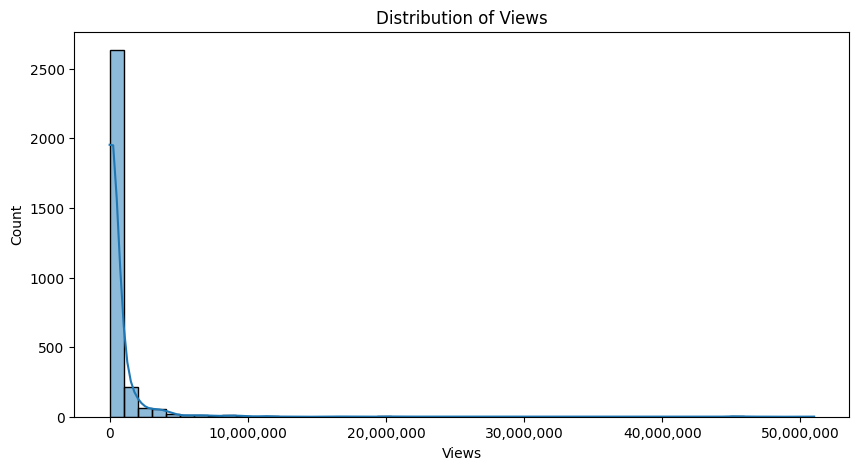

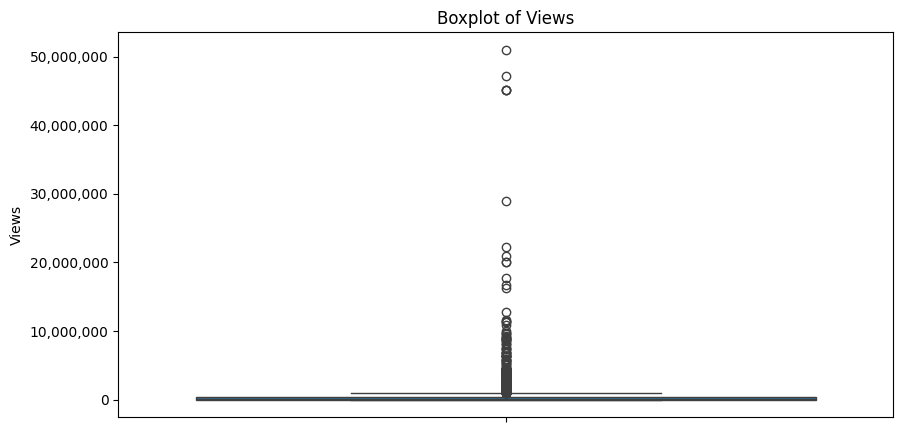

In [13]:
# Histogram for Views
plt.figure(figsize=(10, 5))
sns.histplot(df['views'], bins=50, kde=True)
plt.title('Distribution of Views')
plt.xlabel('Views')
plt.ylabel('Count')
plt.gca().xaxis.set_major_formatter(FuncFormatter(human_format))
plt.show()

# Boxplot for Views
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='views')
plt.title('Boxplot of Views')
plt.ylabel('Views')
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.show()

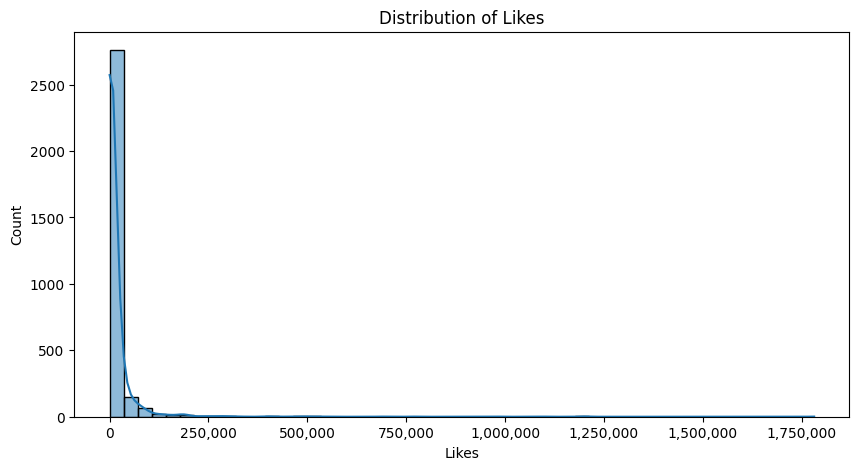

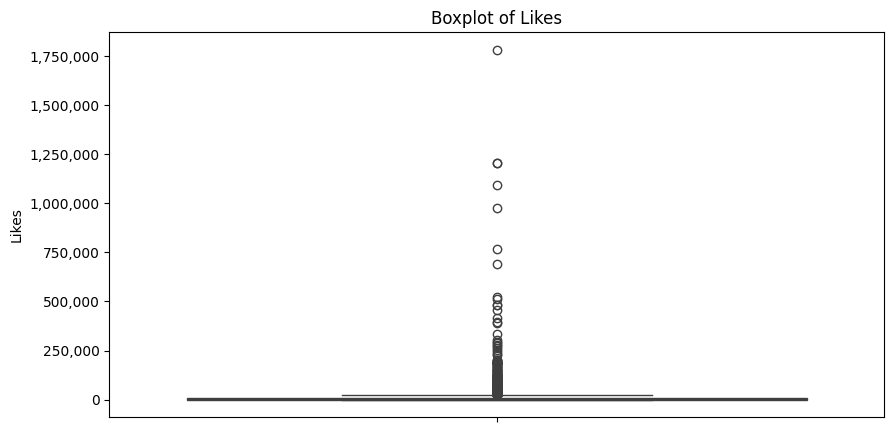

In [14]:
# Histogram for Likes
plt.figure(figsize=(10, 5))
sns.histplot(df['likes'], bins=50, kde=True)
plt.title('Distribution of Likes')
plt.xlabel('Likes')
plt.ylabel('Count')
plt.gca().xaxis.set_major_formatter(FuncFormatter(human_format))
plt.show()

# Boxplot for Likes
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='likes')
plt.title('Boxplot of Likes')
plt.ylabel('Likes')
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.show()

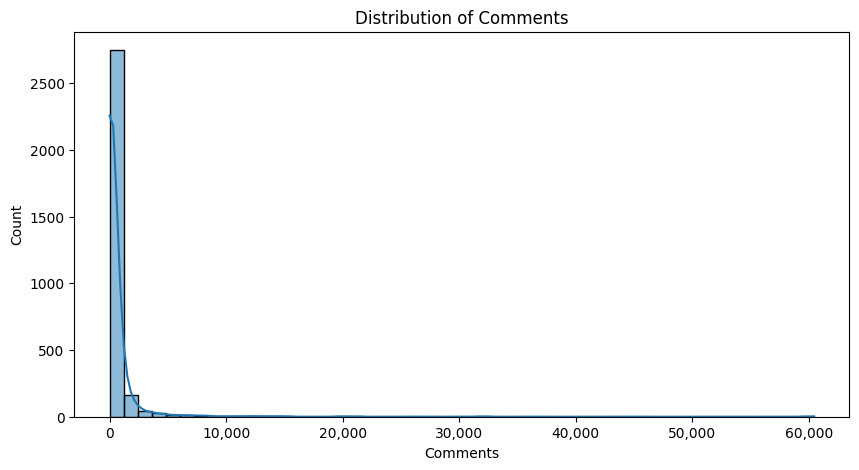

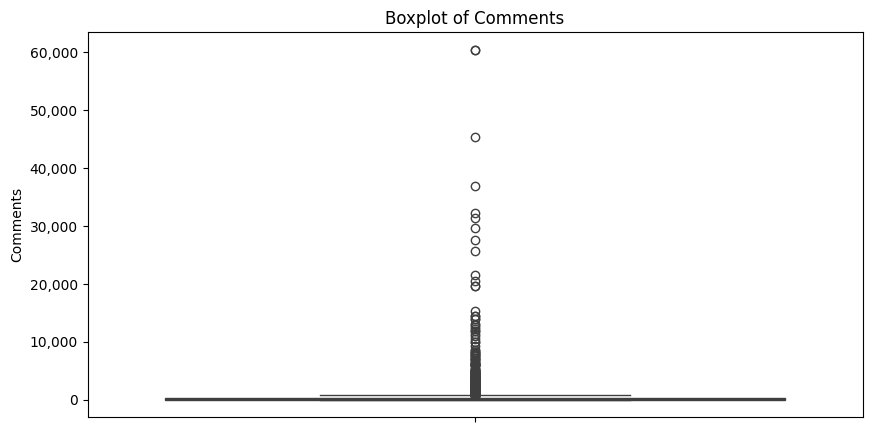

In [15]:
# Histogram for Comments
plt.figure(figsize=(10, 5))
sns.histplot(df['comments'], bins=50, kde=True)
plt.title('Distribution of Comments')
plt.xlabel('Comments')
plt.ylabel('Count')
plt.gca().xaxis.set_major_formatter(FuncFormatter(human_format))
plt.show()

# Boxplot for Comments
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, y='comments')
plt.title('Boxplot of Comments')
plt.ylabel('Comments')
plt.gca().yaxis.set_major_formatter(FuncFormatter(human_format))
plt.show()

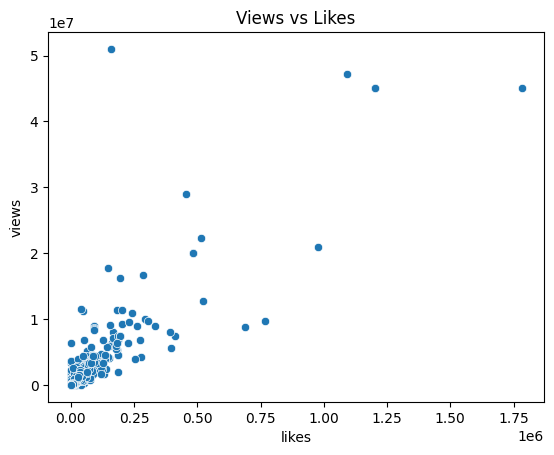

In [16]:
# Scatterplot
sns.scatterplot(data=df, x="likes", y="views")
plt.title("Views vs Likes")
plt.show()

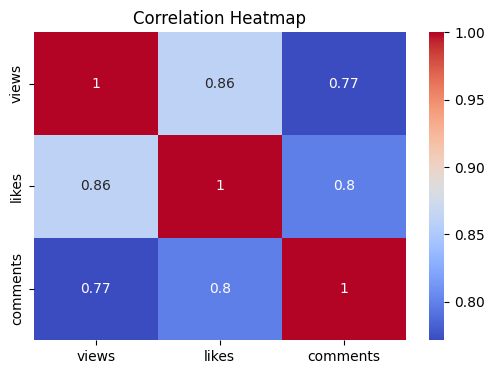

In [17]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[["views", "likes", "comments"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

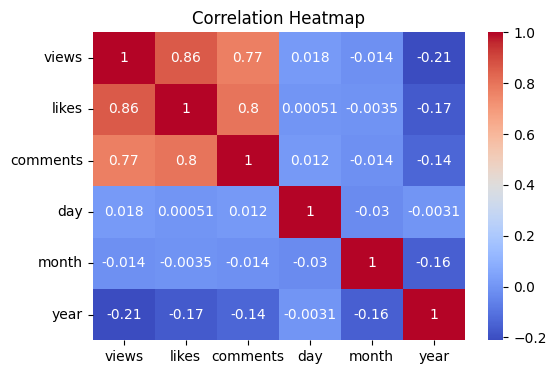

In [18]:
# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[["views", "likes", "comments", "day", "month", "year"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [19]:
# Convert publish time to datetime
df["published"] = pd.to_datetime(df["published"])

# Extract day of week and hour
df["publish_day"] = df["published"].dt.day_name()
df["publish_hour"] = df["published"].dt.hour

# Title features
df["title_length"] = df["title"].astype(str).apply(len)
df["word_count"] = df["title"].astype(str).apply(lambda x: len(x.split()))

# Engagement ratios
df["likes_per_view"] = df["likes"] / df["views"]
df["comments_per_view"] = df["comments"] / df["views"]

df[["title", "views", "likes", "comments", "title_length", "word_count", "likes_per_view", "comments_per_view"]].head()

,title,views,likes,comments,title_length,word_count,likes_per_view,comments_per_view
0,What is Data Science?,793311,16888,305,21,4,0,0
1,Intro to Data Science: What is Data Science?,124740,1788,43,44,8,0,0
2,The Complete Data Science Roadmap,445118,14356,360,33,5,0,0
3,Data Analytics vs Data Science,677108,13757,231,30,5,0,0
4,Data Science In 5 Minutes | Data Science For B...,4421608,62107,1101,92,17,0,0


In [20]:
# Remove videos with 0 views
df = df[df['views'] > 0]

# Remove extreme outliers in likes_per_view
df = df[df['likes_per_view'] < 1]  # likes can't exceed views

# Print how many videos remain
print(f"Videos remaining after filtering: {df.shape[0]}")

Videos remaining after filtering: 2994


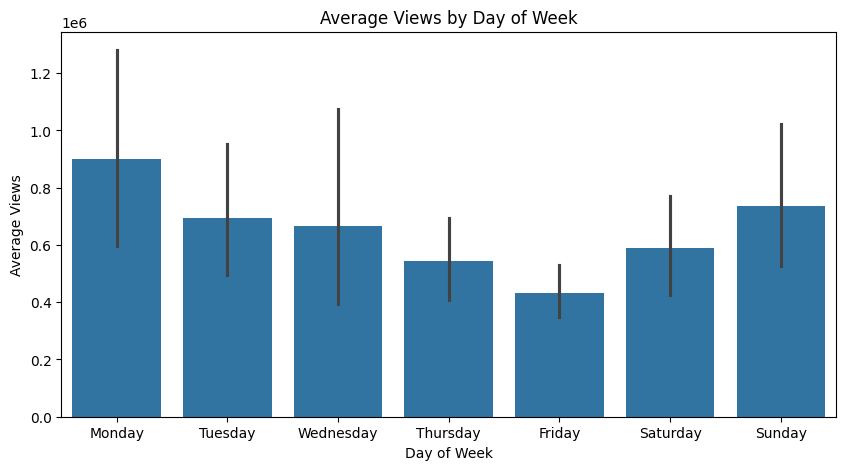

In [21]:
# Average views by publish day
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='publish_day', y='views', estimator='mean', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title('Average Views by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Views')
plt.show()

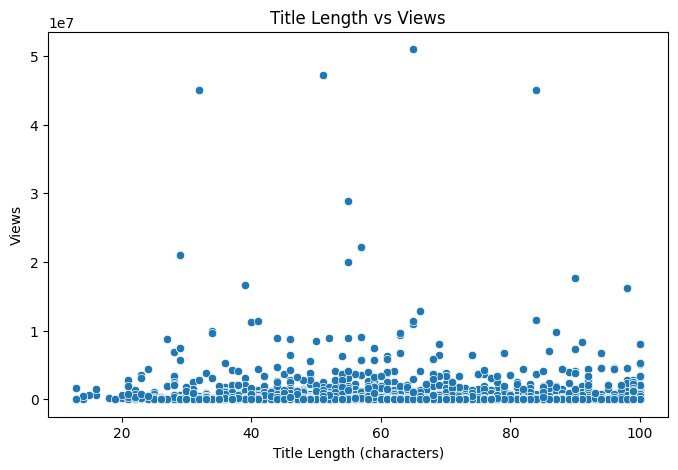

In [22]:
# Title length vs views
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='title_length', y='views')
plt.title('Title Length vs Views')
plt.xlabel('Title Length (characters)')
plt.ylabel('Views')
plt.show()

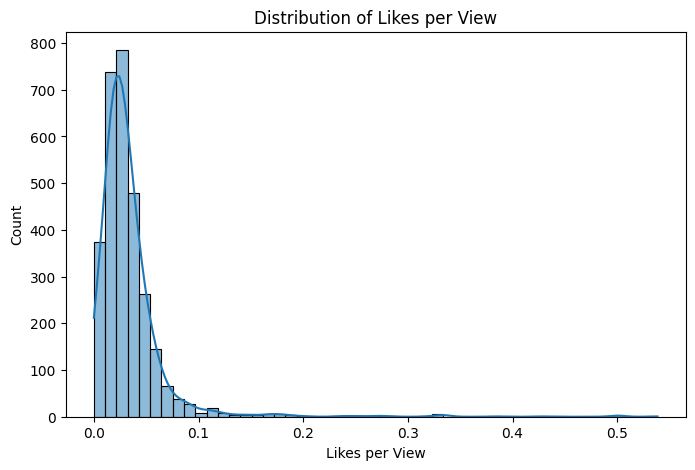

In [23]:
# Likes per view distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['likes_per_view'], bins=50, kde=True)
plt.title('Distribution of Likes per View')
plt.xlabel('Likes per View')
plt.ylabel('Count')
plt.show()

In [24]:
df["month"].value_counts()

month
7     707
6     389
5     325
3     204
2     203
4     203
1     182
9     181
11    156
8     155
12    155
10    134
Name: count, dtype: int64

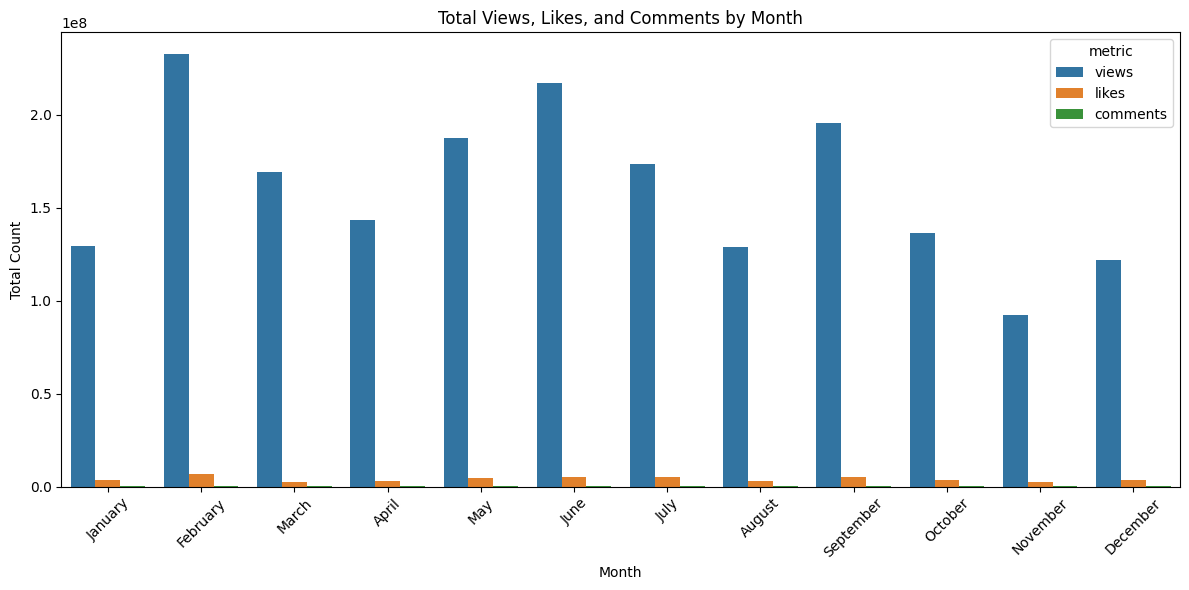

In [25]:
months = {1: "January",
          2: "February",
          3: "March",
          4: "April",
          5: "May",
          6: "June",
          7: "July",
          8: "August",
          9: "September",
          10: "October",
          11: "November",
          12: "December"
}

month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

df["month_name"] = df["month"].map(months)

df_melted = (
    df[["month_name", "views", "likes", "comments"]]
    .groupby("month_name", sort=False)
    .sum()
    .loc[month_order]
    .reset_index()
    .melt(id_vars="month_name", value_vars=["views", "likes", "comments"],
          var_name="metric", value_name="total")
)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="month_name", y="total", hue="metric")
plt.title("Total Views, Likes, and Comments by Month")
plt.xlabel("Month")
plt.ylabel("Total Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Views year over year')

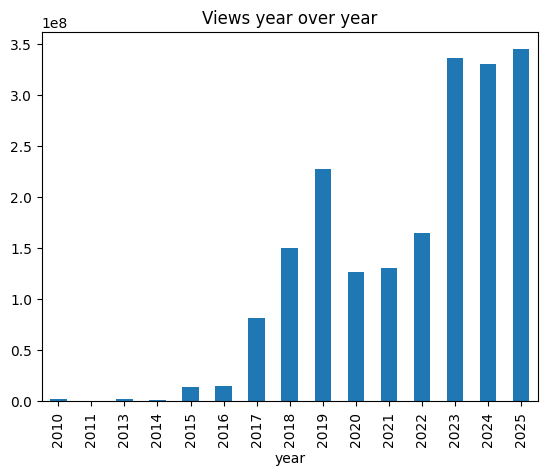

In [26]:
df.groupby("year")["views"].sum().plot(kind="bar")
plt.title("Views year over year")

<Axes: xlabel='publish_hour', ylabel='publish_day'>

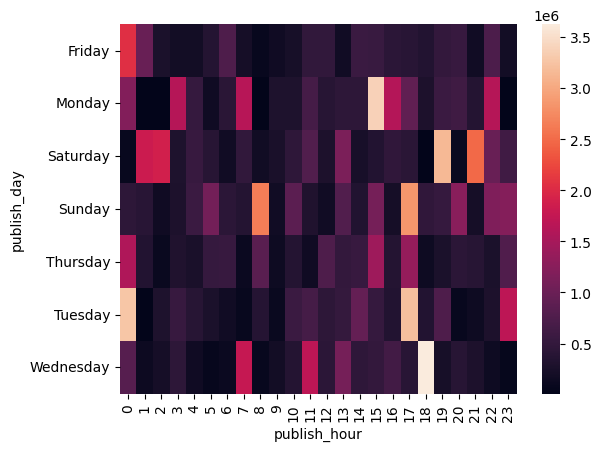

In [27]:
sns.heatmap(df.pivot_table(values="views", index="publish_day", columns="publish_hour", aggfunc="mean"))

In [28]:
df.head()

,keyword,video_id,title,channel,published,views,likes,comments,published_date,year,month,day,publish_day,publish_hour,title_length,word_count,likes_per_view,comments_per_view,month_name
0,data science,RBSUwFGa6Fk,What is Data Science?,IBM Technology,2022-06-13 12:00:14+00:00,793311,16888,305,12:00:14,2022,6,13,Monday,12,21,4,0,0,June
1,data science,FsSrzmRawUg,Intro to Data Science: What is Data Science?,Steve Brunton,2019-06-06 05:19:06+00:00,124740,1788,43,05:19:06,2019,6,6,Thursday,5,44,8,0,0,June
2,data science,9R3X0JoCLyU,The Complete Data Science Roadmap,Programming with Mosh,2024-08-01 13:00:08+00:00,445118,14356,360,13:00:08,2024,8,1,Thursday,13,33,5,0,0,August
3,data science,dcXqhMqhZUo,Data Analytics vs Data Science,IBM Technology,2023-11-08 12:00:38+00:00,677108,13757,231,12:00:38,2023,11,8,Wednesday,12,30,5,0,0,November
4,data science,X3paOmcrTjQ,Data Science In 5 Minutes | Data Science For B...,Simplilearn,2018-12-04 14:30:01+00:00,4421608,62107,1101,14:30:01,2018,12,4,Tuesday,14,92,17,0,0,December


## Final Preprocessing (Ready for modeling)

In [29]:
"""Preprocessing for modeling"""
def build_preprocessor():
    text_col = "title"

    numeric_features = [
        "title_length", "word_count", "publish_hour", 
        "likes_per_view", "comments_per_view"
    ]

    categorical_features = ["keyword"]

    """We're using a transformer to transform our title into useable features for predicting modeling which we will latter in this project"""
    text_transformer = TfidfVectorizer(
        max_features=100,
        stop_words="english"
    )

    numeric_transformer = StandardScaler()

    categorical_transformer = OneHotEncoder(handle_unknown="ignore")


    preprocessor = ColumnTransformer(
        transformers=[
            ("text", text_transformer, text_col),
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )
    return preprocessor

In [30]:
preprocessor = build_preprocessor()
X_pre = preprocessor.fit_transform(df)


In [31]:
X_tfidf = preprocessor.named_transformers_["text"].transform(df["title"])
X_num = preprocessor.named_transformers_["num"].transform(df[["title_length", "word_count", "publish_hour", "likes_per_view", "comments_per_view"]])
X_cat = preprocessor.named_transformers_["cat"].transform(df[["keyword"]])

In [37]:
svd = TruncatedSVD(n_components=50, random_state=42)
X_tfidf_svd = svd.fit_transform(X_tfidf)

In [38]:
X_all = hstack([X_tfidf_svd, X_num, X_cat])

tfidf_names = [f"svd_{i}" for i in range(X_tfidf_svd.shape[1])]
numeric_names = preprocessor.transformers_[1][2]
cat_names = preprocessor.named_transformers_["cat"].get_feature_names_out(["keyword"])

X_df = pd.DataFrame(X_all.toarray(), columns=tfidf_names + list(numeric_names) + list(cat_names))
X_df.head()

,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,...,title_length,word_count,publish_hour,likes_per_view,comments_per_view,keyword_artificial intelligence,keyword_data analytics,keyword_data science,keyword_machine learning,keyword_python tutorial
0,0,-0,1,-0,-0,0,-0,-0,0,-0,...,-2,-2,-0,-0,-0,0,0,1,0,0
1,0,-0,1,-0,-0,0,-0,-0,0,-0,...,-1,-1,-1,-1,-0,0,0,1,0,0
2,0,-0,0,-0,-0,0,0,-0,0,0,...,-2,-2,0,-0,-0,0,0,1,0,0
3,0,-0,1,-0,-0,0,0,0,-0,0,...,-2,-2,-0,-0,-0,0,0,1,0,0
4,0,-0,1,-0,-0,0,0,-0,0,-0,...,1,2,0,-1,-0,0,0,1,0,0


In [39]:
# Add target column to X_df
X_df["views"] = df["views"]

# Save to CSV for modeling
X_df.to_csv("preprocessed_youtube_data.csv", index=False)